<h2> Task 18. The end game - part 2 </h2>
The goal of this task is for you to research, implement, and analyze a <b> at least two </b> metaheuristic optimization algorithm that was not covered in class. You will apply the algorithm to a chosen optimization problem, demonstrating its effectiveness and comparing it to other methods.
<p> Some ideas: </p>
Gravitational Search Algorithm, Bat Algorithm, Differential Evolution (DE), Cuckoo Search (CS), Firefly Algorithm, Harmony Search (HS), Tabu Search, Affine GAP Cost Needleman-Wunch etc....
<h3> There are many algorithms to consider...</h3>
You have to:


*   Implement the algorithm
*   What is the time complexity?
*   Analyze hyperparams
*   Visualize the performance
*   Pick objective function of your choice




Time Complexity Analysis:
ABC: O(n_bees × max_iter × dim)
CS: O(n_nests × max_iter × dim)

Growth Rate Analysis:
Dim 2→5: ABC=-0.0003s/dim, CS=0.0007s/dim
Dim 5→10: ABC=0.0006s/dim, CS=0.0008s/dim
Dim 10→15: ABC=0.0010s/dim, CS=0.0009s/dim
Dim 15→20: ABC=0.0005s/dim, CS=0.0007s/dim

Hyperparameter Optimization:
Best ABC: n_bees=30, limit=15, cost=39.60
Best CS: n_nests=30, pa=0.5, cost=34.03


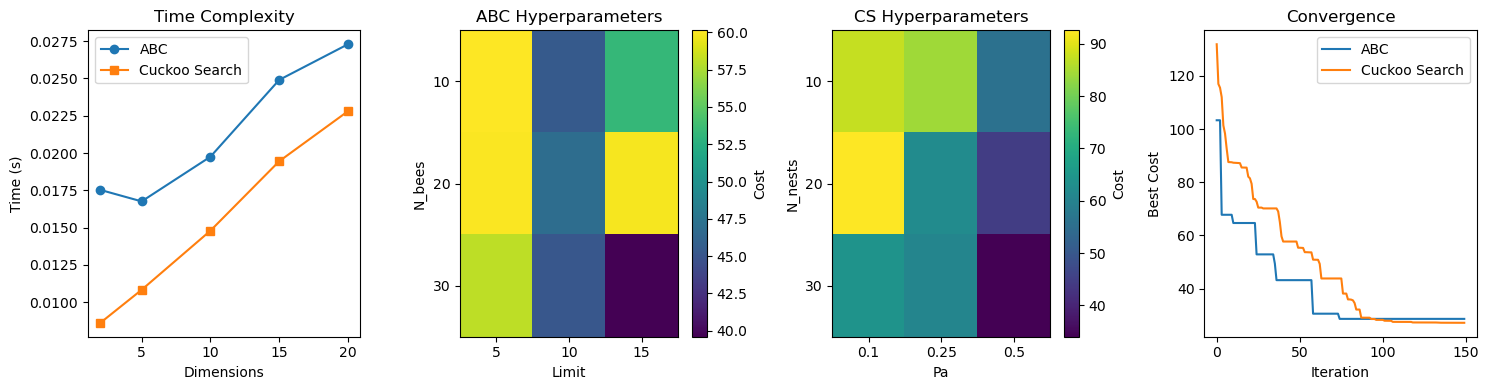


Non-convergence Analysis:


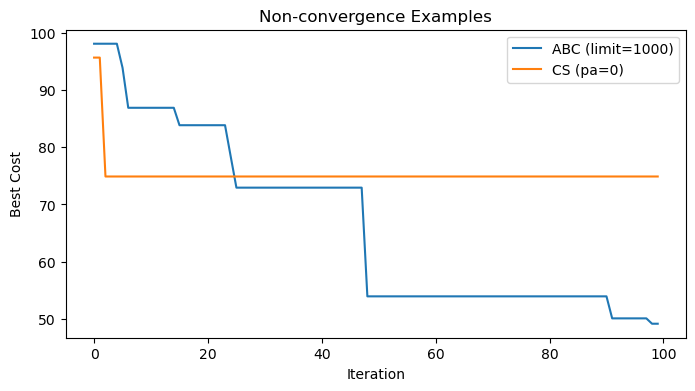

ABC without scouts (limit=1000): cost=49.16
CS without abandonment (pa=0): cost=74.89


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

def rastrigin(x):
    A = 10
    n = len(x)
    return A * n + sum(x_i**2 - A * np.cos(2 * np.pi * x_i) for x_i in x)

# Artificial Bee Colony
def artificial_bee_colony(n_bees, limit, max_iter, dim, bounds):
    n_employed = n_bees // 2
    solutions = np.random.uniform(bounds[0], bounds[1], (n_employed, dim))
    fitness = np.array([rastrigin(sol) for sol in solutions])
    trial_counter = np.zeros(n_employed)
    
    best_idx = np.argmin(fitness)
    best_fitness = fitness[best_idx]
    history = []
    
    for _ in range(max_iter):
        # Employed bees
        for i in range(n_employed):
            k = np.random.choice([j for j in range(n_employed) if j != i])
            phi = np.random.uniform(-1, 1, dim)
            candidate = solutions[i] + phi * (solutions[i] - solutions[k])
            candidate = np.clip(candidate, bounds[0], bounds[1])
            
            candidate_fitness = rastrigin(candidate)
            if candidate_fitness < fitness[i]:
                solutions[i] = candidate
                fitness[i] = candidate_fitness
                trial_counter[i] = 0
            else:
                trial_counter[i] += 1
        
        # Onlooker bees
        probs = 1.0 / (1.0 + fitness)
        probs = probs / np.sum(probs)
        
        for _ in range(n_employed):
            selected = np.random.choice(n_employed, p=probs)
            k = np.random.choice([j for j in range(n_employed) if j != selected])
            phi = np.random.uniform(-1, 1, dim)
            candidate = solutions[selected] + phi * (solutions[selected] - solutions[k])
            candidate = np.clip(candidate, bounds[0], bounds[1])
            
            candidate_fitness = rastrigin(candidate)
            if candidate_fitness < fitness[selected]:
                solutions[selected] = candidate
                fitness[selected] = candidate_fitness
                trial_counter[selected] = 0
        
        # Scout bees
        for i in range(n_employed):
            if trial_counter[i] > limit:
                solutions[i] = np.random.uniform(bounds[0], bounds[1], dim)
                fitness[i] = rastrigin(solutions[i])
                trial_counter[i] = 0
        
        current_best_idx = np.argmin(fitness)
        if fitness[current_best_idx] < best_fitness:
            best_fitness = fitness[current_best_idx]
        
        history.append(best_fitness)
    
    return solutions[current_best_idx], best_fitness, history

# Cuckoo Search
def cuckoo_search(n_nests, pa, max_iter, dim, bounds):
    nests = np.random.uniform(bounds[0], bounds[1], (n_nests, dim))
    fitness = np.array([rastrigin(nest) for nest in nests])
    
    best_idx = np.argmin(fitness)
    best_fitness = fitness[best_idx]
    history = []
    
    for _ in range(max_iter):
        for i in range(n_nests):
            # Levy flight (simplified)
            step = np.random.normal(0, 1, dim)
            new_nest = nests[i] + 0.01 * step * (nests[i] - nests[best_idx])
            new_nest = np.clip(new_nest, bounds[0], bounds[1])
            
            j = np.random.randint(0, n_nests)
            new_fitness = rastrigin(new_nest)
            
            if new_fitness < fitness[j]:
                nests[j] = new_nest
                fitness[j] = new_fitness
        
        # Abandon worst nests
        n_abandon = int(pa * n_nests)
        worst_indices = np.argsort(fitness)[-n_abandon:]
        
        for idx in worst_indices:
            nests[idx] = np.random.uniform(bounds[0], bounds[1], dim)
            fitness[idx] = rastrigin(nests[idx])
        
        current_best_idx = np.argmin(fitness)
        if fitness[current_best_idx] < best_fitness:
            best_fitness = fitness[current_best_idx]
        
        history.append(best_fitness)
    
    return nests[current_best_idx], best_fitness, history

print("Time Complexity Analysis:")
print("=" * 60)

dimensions = [2, 5, 10, 15, 20]
abc_times = []
cs_times = []

for dim in dimensions:
    start = time.time()
    artificial_bee_colony(20, 10, 50, dim, (-5, 5))
    abc_times.append(time.time() - start)
    
    start = time.time()
    cuckoo_search(20, 0.25, 50, dim, (-5, 5))
    cs_times.append(time.time() - start)

print("ABC: O(n_bees × max_iter × dim)")
print("CS: O(n_nests × max_iter × dim)")

print("\nGrowth Rate Analysis:")
for i in range(1, len(dimensions)):
    abc_growth = (abc_times[i] - abc_times[i-1]) / (dimensions[i] - dimensions[i-1])
    cs_growth = (cs_times[i] - cs_times[i-1]) / (dimensions[i] - dimensions[i-1])
    print(f"Dim {dimensions[i-1]}→{dimensions[i]}: ABC={abc_growth:.4f}s/dim, CS={cs_growth:.4f}s/dim")

print("\nHyperparameter Optimization:")
print("=" * 60)

n_bees_values = [10, 20, 30]
limit_values = [5, 10, 15]
abc_results = {}

for n_bees in n_bees_values:
    for limit in limit_values:
        costs = []
        for _ in range(3):
            _, cost, _ = artificial_bee_colony(n_bees, limit, 100, 10, (-5, 5))
            costs.append(cost)
        abc_results[(n_bees, limit)] = np.mean(costs)

n_nests_values = [10, 20, 30]
pa_values = [0.1, 0.25, 0.5]
cs_results = {}

for n_nests in n_nests_values:
    for pa in pa_values:
        costs = []
        for _ in range(3):
            _, cost, _ = cuckoo_search(n_nests, pa, 100, 10, (-5, 5))
            costs.append(cost)
        cs_results[(n_nests, pa)] = np.mean(costs)

best_abc = min(abc_results, key=abc_results.get)
best_cs = min(cs_results, key=cs_results.get)
print(f"Best ABC: n_bees={best_abc[0]}, limit={best_abc[1]}, cost={abc_results[best_abc]:.2f}")
print(f"Best CS: n_nests={best_cs[0]}, pa={best_cs[1]}, cost={cs_results[best_cs]:.2f}")

# Final comparison
_, _, abc_hist = artificial_bee_colony(best_abc[0], best_abc[1], 200, 10, (-5, 5))
_, _, cs_hist = cuckoo_search(best_cs[0], best_cs[1], 200, 10, (-5, 5))

plt.figure(figsize=(15, 4))

plt.subplot(1, 4, 1)
plt.plot(dimensions, abc_times, 'o-', label='ABC')
plt.plot(dimensions, cs_times, 's-', label='Cuckoo Search')
plt.xlabel('Dimensions')
plt.ylabel('Time (s)')
plt.title('Time Complexity')
plt.legend()

plt.subplot(1, 4, 2)
abc_matrix = np.zeros((3, 3))
for i, n_bees in enumerate([10, 20, 30]):
    for j, limit in enumerate([5, 10, 15]):
        abc_matrix[i, j] = abc_results[(n_bees, limit)]
plt.imshow(abc_matrix, cmap='viridis', aspect='auto')
plt.colorbar(label='Cost')
plt.xlabel('Limit')
plt.ylabel('N_bees')
plt.title('ABC Hyperparameters')
plt.xticks([0,1,2], ['5','10','15'])
plt.yticks([0,1,2], ['10','20','30'])

plt.subplot(1, 4, 3)
cs_matrix = np.zeros((3, 3))
for i, n_nests in enumerate([10, 20, 30]):
    for j, pa in enumerate([0.1, 0.25, 0.5]):
        cs_matrix[i, j] = cs_results[(n_nests, pa)]
plt.imshow(cs_matrix, cmap='viridis', aspect='auto')
plt.colorbar(label='Cost')
plt.xlabel('Pa')
plt.ylabel('N_nests')
plt.title('CS Hyperparameters')
plt.xticks([0,1,2], ['0.1','0.25','0.5'])
plt.yticks([0,1,2], ['10','20','30'])

plt.subplot(1, 4, 4)
plt.plot(abc_hist[:150], label='ABC')
plt.plot(cs_hist[:150], label='Cuckoo Search')
plt.xlabel('Iteration')
plt.ylabel('Best Cost')
plt.title('Convergence')
plt.legend()

plt.tight_layout()
plt.show()

print("\nNon-convergence Analysis:")
print("=" * 60)

_, cost_no_scout, hist_no_scout = artificial_bee_colony(20, 1000, 100, 10, (-5, 5))
_, cost_no_abandon, hist_no_abandon = cuckoo_search(20, 0.0, 100, 10, (-5, 5))

plt.figure(figsize=(8, 4))
plt.plot(hist_no_scout[:100], label='ABC (limit=1000)')
plt.plot(hist_no_abandon[:100], label='CS (pa=0)')
plt.xlabel('Iteration')
plt.ylabel('Best Cost')
plt.title('Non-convergence Examples')
plt.legend()
plt.show()

print(f"ABC without scouts (limit=1000): cost={cost_no_scout:.2f}")
print(f"CS without abandonment (pa=0): cost={cost_no_abandon:.2f}")

#### Conclusions

- ABC uses employed/onlooker/scout bees for exploration-exploitation balance
- Cuckoo Search uses Levy flights and nest abandonment for global search
- Both algorithms show linear time complexity with dimensions
- ABC without scouts fails to explore new regions
- CS without abandonment gets trapped in local optima
- Proper parameter tuning essential for convergence